In [99]:
import numpy as np
from numpy import kron
import qiskit as qk

### Decompose the 4x4 Hamiltonian matrix into a sum of tensor products of Pauli matrices using the formula in the notes

In [148]:
def decomposition(H):
    """Decompose any 4x4 Hermitian matrix into a sum of tensor products of two Pauli matrices
    """
    identity = np.array([[1, 0],[ 0, 1]], dtype=np.complex128)
    x = np.array([[0, 1],  [ 1, 0]], dtype=np.complex128)
    y = np.array([[0, -1j],[1j, 0]], dtype=np.complex128)
    z = np.array([[1, 0],  [0, -1]], dtype=np.complex128)
    S = [identity, x, y, z]
    labels = ['I', 'sigma_x', 'sigma_y', 'sigma_z']
    d = {'00': 'I product I', '01': 'I product sigma_x', '02': 'I product sigma_y', '03': 'I product sigma_z', 
        '10': 'sigma_x product I', '11': 'sigma_x product sigma_x', '12': 'sigma_x product sigma_y', 
        '13': 'sigma_x product sigma_z', '20': 'sigma_y product I', '21': 'sigma_y product sigma_x', 
        '22': 'sigma_y product sigma_y', '23': 'sigma_y product sigma_z', '30': 'sigma_z product I', 
        '31': 'sigma_z product sigma_x', '32': 'sigma_z product sigma_y', '33': 'sigma_z product sigma_z'}
    for i in range(4):
        for j in range(4):
            a_ij = 0.25 * np.dot(kron(S[i], S[j]), H).trace()
            if a_ij != 0.0:
                print(str(a_ij) + ' * ' + d[str(i)+str(j)])

In [101]:
H = np.array([[0,0,0,0],[0,-1,1,0],[0,1,-1,0],[0,0,0,0]])
decomposition(H)

(-0.5+0j) * I product I
(0.5+0j) * sigma_x product sigma_x
(0.5+0j) * sigma_y product sigma_y
(0.5+0j) * sigma_z product sigma_z


### Allocate a circuit with 2 qubits and 2 classical bits.
### Our Hamiltonian is a sum of tensor products of two sigma_x matrices, two sigma_y matrices, two sigma_z matrices, and two 2x2 identity matrices (see notes)

In [102]:
def prepare_state(theta, n=3):
    """
    Prepare three 2-qubit states with 3 associated quantum registers, 3 associated classical registers, 
    and 3 quantum circuits.  We will prepare the state with the ansatz mentioned in the notes in which we act on
    the first qubit with the Hadamard operator, then with the R_z operator, then we act on the 2-qubit state
    with the CNOT gate, and then on the second qubit in each terms of the superposition with the sigma_x operator.
    After that, we will take the first circuit and act on each qubit with the R_y(pi/2) operator, and take the second
    circuit and act on each qubit with the R_x(-pi/2) operator as explained in the notes. We do this so that those
    qubits will be in the basis of eigenvectors of sigma_x and sigma_y as explained in the notes.  We can measure
    the qubits in the other circuit as-is because we need the expectation value of sigma_z and the qubits are already
    in the computational basis.
    """
    qr0 = qk.QuantumRegister(2)
    cr0 = qk.ClassicalRegister(2)
    qc0 = qk.QuantumCircuit(qr0,cr0)
    qr1 = qk.QuantumRegister(2)
    cr1 = qk.ClassicalRegister(2)
    qc1 = qk.QuantumCircuit(qr1,cr1)
    qr2 = qk.QuantumRegister(2)
    cr2 = qk.ClassicalRegister(2)
    qc2 = qk.QuantumCircuit(qr2,cr2)
    
    qregisters = [qr0,qr1,qr2]
    cregisters = [cr0,cr1,cr2]
    qcircuits = [qc0,qc1,qc2]
    
    for i in range(n):
        qcircuits[i].h(qregisters[i][0])
    for i in range(n):
        qcircuits[i].rz(theta, qregisters[i][0])
    for i in range(n):
        qcircuits[i].cx(qregisters[i][0], qregisters[i][1])
    for i in range(n):
        qcircuits[i].x(qregisters[i][1])
        
    qcircuits[0].ry((np.pi)/2, qregisters[0][0])
    qcircuits[0].ry((np.pi)/2, qregisters[0][1])
    qcircuits[1].rx(-(np.pi)/2, qregisters[1][0])
    qcircuits[1].rx(-(np.pi)/2, qregisters[1][1])
    
    return qregisters, cregisters, qcircuits

### Here is what the circuits look like after they have been prepared

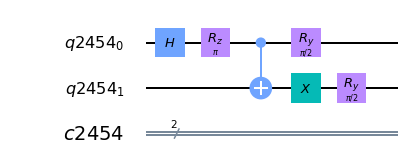

In [103]:
qregisters, cregisters, qcircuits = prepare_state(np.pi, n=3)
qcircuits[0].draw(output='mpl')

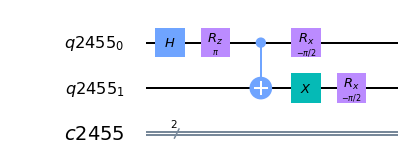

In [104]:
qcircuits[1].draw(output='mpl')

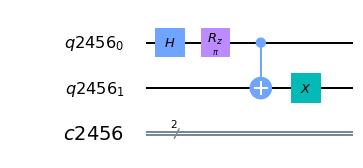

In [105]:
qcircuits[2].draw(output='mpl')

### Calculate the expectation value of the sigma_x, sigma_y, and sigma_z terms (expectation value of the identity operator tensor product is just 1 because the ansatz is normalized) by preparing the state in the appropriate basis 5000 times and measuring the state each time.  If the measurement is |01> or |10>, then multiply the number of times those states appear by -1.  If the measurement is |00> or |11>, then multiply the number of times those states appear by 1.  Finally, divide the sum by 5000, and multiply by 0.5 if we are calculating the expectation value of sigma_x X sigma_x or sigma_y X sigma_y or sigma_z X sigma_z.  Then take the result and subtract 0.5 (expectation value of identity X identity).

In [106]:
def expectation(qcircuits, cregisters, qregisters, n_shots, n=3):
    """
    For each circuit, execute and measure it using the classical simulator 5000 times as explained above. Multiply
    each of the three expectation values by 0.5, add them up, and subtract -0.5.  Return the result.
    """
    expect = -0.5
    for i in range(n):
        qcircuits[i].measure(qregisters[i],cregisters[i])
        qk.Aer.backends()
        sim = qk.Aer.get_backend('qasm_simulator')
        res = qk.execute(qcircuits[i], sim, shots=n_shots).result()
        counts = res.get_counts()
        sum = 0
        for k,v in counts.items():
            if k=='01' or k=='10':
                sum += (-1)*v/n_shots
            elif k=='00' or k=='11':
                sum += v/n_shots
        sum = 0.5*sum
        expect += sum
    return expect

In [107]:
# Consider 100 values of theta, between 0 and Pi.  This theta is the one used in state preparation.
thetas = np.linspace(0, np.pi, 100)

In [108]:
# For each theta, store the resulting expectation value in results
results = []
# For each theta, find the expectation value
for theta in thetas:
    qregisters, cregisters, qcircuits = prepare_state(theta, n=3)
    expect = expectation(qcircuits, cregisters, qregisters, 5000, n=3)
    results.append(expect)
# Sort the results in ascending order.  The first one is your minimum eigenvalue.
results.sort()
print("The minimum eigenvalue is: {}.".format(results[0]))

The minimum eigenvalue is: -2.0.


In [109]:
from qiskit import IBMQ
#IBMQ.delete_account()
IBMQ.save_account('my IBM token', overwrite=True)
IBMQ.load_account()

Credentials are already in use. The existing account in the session will be replaced.


<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

In [110]:
provider = IBMQ.get_provider()
procs=provider.backends(operational=True, simulator=False)

In [111]:
from qiskit.tools.jupyter import *
%qiskit_backend_overview

In [112]:
from qiskit.tools import monitor
backend = qk.providers.ibmq.least_busy([p for p in procs if len(p.properties().qubits) >= 2])

In [113]:
from qiskit.tools.monitor import backend_overview, backend_monitor
backend_monitor(backend)

ibmq_london
Configuration
-------------
    n_qubits: 5
    operational: True
    status_msg: active
    pending_jobs: 2
    backend_version: 1.0.1
    basis_gates: ['u1', 'u2', 'u3', 'cx', 'id']
    local: False
    simulator: False
    coupling_map: [[0, 1], [1, 0], [1, 2], [1, 3], [2, 1], [3, 1], [3, 4], [4, 3]]
    open_pulse: False
    credits_required: True
    description: 5 qubit device London
    url: None
    allow_object_storage: True
    conditional: False
    quantum_volume: 16
    backend_name: ibmq_london
    sample_name: Giraffe
    max_shots: 8192
    allow_q_circuit: False
    max_experiments: 75
    online_date: 2019-09-13T04:00:00+00:00
    memory: True
    allow_q_object: True
    n_registers: 1

Qubits [Name / Freq / T1 / T2 / U1 err / U2 err / U3 err / Readout err]
-----------------------------------------------------------------------
    Q0 / 5.25406 GHz / 33.12544 µs / 51.29511 µs / 0.0 / 0.00097 / 0.00194 / 0.03167
    Q1 / 5.04877 GHz / 79.50631 µs / 69.4155

In [129]:
def q_expectation(qcircuits, cregisters, qregisters, n_shots, n=3):
    """
    For each circuit, execute and measure it using the classical simulator 5000 times as explained above. Multiply
    each of the three expectation values by 0.5, add them up, and subtract -0.5.  Return the result.
    """
    expect = -0.5
    for i in range(n):
        qcircuits[i].measure(qregisters[i],cregisters[i])
        qk.Aer.backends()
        sim = qk.Aer.get_backend('qasm_simulator')
        res = qk.execute(qcircuits[i], backend=backend, shots=n_shots).result()
        #mon = monitor.job_monitor(res)
        counts = res.get_counts()
        sum = 0
        for k,v in counts.items():
            if k=='01' or k=='10':
                sum += (-1)*v/n_shots
            elif k=='00' or k=='11':
                sum += v/n_shots
        sum = 0.5*sum
        expect += sum
    return expect

In [136]:
# Consider 10 values of theta, between 0 and Pi.  This theta is the one used in state preparation.
thetas = np.linspace(0, np.pi, 10)

In [137]:
# Use n_shots = 100
results = []
# For each theta, find the expectation value
for theta in thetas:
    qregisters, cregisters, qcircuits = prepare_state(theta, n=3)
    expect = q_expectation(qcircuits, cregisters, qregisters, 100, n=3)
    results.append(expect)
# Sort the results in ascending order.  The first one is your minimum eigenvalue.
results.sort()
print("The minimum eigenvalue is: {}.".format(results[0]))

The minimum eigenvalue is: -1.67.


In [138]:
# Use n_shots = 1000
results = []
# For each theta, find the expectation value
for theta in thetas:
    qregisters, cregisters, qcircuits = prepare_state(theta, n=3)
    expect = q_expectation(qcircuits, cregisters, qregisters, 1000, n=3)
    results.append(expect)
# Sort the results in ascending order.  The first one is your minimum eigenvalue.
results.sort()
print("The minimum eigenvalue is: {}.".format(results[0]))

The minimum eigenvalue is: -1.6809999999999998.


In [139]:
# Use n_shots = 5000
results = []
# For each theta, find the expectation value
for theta in thetas:
    qregisters, cregisters, qcircuits = prepare_state(theta, n=3)
    expect = q_expectation(qcircuits, cregisters, qregisters, 5000, n=3)
    results.append(expect)
# Sort the results in ascending order.  The first one is your minimum eigenvalue.
results.sort()
print("The minimum eigenvalue is: {}.".format(results[0]))

The minimum eigenvalue is: -1.6832.


## Since we already know the minimum is achieved with theta = pi, let's increase the shot
## count and just use theta = pi and see what results we get.  Let's try to get closer to -2.

In [141]:
# Use n_shots = 8192 = max allowed
results = []
thetas = [np.pi]
# For each theta, find the expectation value
for theta in thetas:
    qregisters, cregisters, qcircuits = prepare_state(theta, n=3)
    expect = q_expectation(qcircuits, cregisters, qregisters, 8192, n=3)
    results.append(expect)
# Sort the results in ascending order.  The first one is your minimum eigenvalue.
results.sort()
print("The minimum eigenvalue is: {}.".format(results[0]))

The minimum eigenvalue is: -1.6815185546875.


### I thought I would keep the fun going and write a script that will decompose any 4x4 Hermitian matrix and find
### the smallest eigenvalue.  Ran into a hiccup.

In [149]:
def decomposition(H):
    """Decompose any 4x4 Hermitian matrix into a sum of tensor products of two Pauli matrices
    """
    A_ij = []
    identity = np.array([[1, 0],[ 0, 1]], dtype=np.complex128)
    x = np.array([[0, 1],  [ 1, 0]], dtype=np.complex128)
    y = np.array([[0, -1j],[1j, 0]], dtype=np.complex128)
    z = np.array([[1, 0],  [0, -1]], dtype=np.complex128)
    S = [identity, x, y, z]
    labels = ['I', 'sigma_x', 'sigma_y', 'sigma_z']
    d = {'00': 'I product I', '01': 'I product sigma_x', '02': 'I product sigma_y', '03': 'I product sigma_z', 
        '10': 'sigma_x product I', '11': 'sigma_x product sigma_x', '12': 'sigma_x product sigma_y', '13': 'sigma_x product sigma_z',
        '20': 'sigma_y product I', '21': 'sigma_y product sigma_x', '22': 'sigma_y product sigma_y', '23': 'sigma_y product sigma_z',
        '30': 'sigma_z product I', '31': 'sigma_z product sigma_x', '32': 'sigma_z product sigma_y', '33': 'sigma_z product sigma_z'}
    for i in range(4):
        for j in range(4):
            a_ij = 0.25 * np.dot(kron(S[i], S[j]), H).trace()
            A_ij.append(a_ij)
            if a_ij != 0.0:
                print(str(a_ij) + ' * ' + d[str(i)+str(j)])
    return np.asarray(A_ij).reshape(4,4)

In [154]:
def prepare_state2(A, theta):
    qregisters = []
    cregisters = []
    qcircuits = []
    identity = np.array([[1, 0],[ 0, 1]], dtype=np.complex128)
    x = np.array([[0, 1],  [ 1, 0]], dtype=np.complex128)
    y = np.array([[0, -1j],[1j, 0]], dtype=np.complex128)
    z = np.array([[1, 0],  [0, -1]], dtype=np.complex128)
    d = {}
    for i in range(4):
        for j in range(4):
            if A[i,j] != 0:
                if i !=0 and j!=0:
                    qr = qk.QuantumRegister(2)
                    cr = qk.ClassicalRegister(2)
                    qc = qk.QuantumCircuit(qr,cr)
                    qc.h(qr[0])
                    qc.rz(theta, qr[0])
                    qc.cx(qr[0], qr[1])
                    qc.x(qr[1])
                    if i==1:
                        qc.ry((np.pi)/2, qr[0])
                    if i==2:
                        qc.rx(-(np.pi)/2, qr[0])
                    if j==1:
                        qc.ry((np.pi)/2, qr[1])
                    if j==2:
                        qc.rx(-(np.pi)/2, qr[1])
                    qregisters.append(qr)
                    cregisters.append(cr)
                    qcircuits.append(qc)
                    d[(i,j)] = [qregisters, cregisters, qcircuits]
                if i == 0 and j != 0:
                    qr = qk.QuantumRegister(2)
                    cr = qk.ClassicalRegister(2)
                    qc = qk.QuantumCircuit(qr,cr)
                    qc.h(qr[0])
                    qc.rz(theta, qr[0])
                    qc.cx(qr[0], qr[1])
                    qc.x(qr[1])
                    if j==1:
                        qc.ry((np.pi)/2, qr[1])
                    if j==2:
                        qc.rx(-(np.pi)/2, qr[1])
                    qregisters.append(qr)
                    cregisters.append(cr)
                    qcircuits.append(qc)
                    d[(i,j)] = [qregisters, cregisters, qcircuits]
                if i != 0 and j == 0:
                    qr = qk.QuantumRegister(2)
                    cr = qk.ClassicalRegister(2)
                    qc = qk.QuantumCircuit(qr,cr)
                    qc.h(qr[0])
                    qc.rz(theta, qr[0])
                    qc.cx(qr[0], qr[1])
                    qc.x(qr[1])
                    if i==1:
                        qc.ry((np.pi)/2, qr[0])
                    if i==2:
                        qc.rx(-(np.pi)/2, qr[0])
                    qregisters.append(qr)
                    cregisters.append(cr)
                    qcircuits.append(qc)
                    d[(i,j)] = [qregisters, cregisters, qcircuits]
    return d, A

In [155]:
def expectation2(d, A, n_shots):
    """
    For each circuit, execute and measure it using the classical simulator 5000 times as explained above. 
    Return the result.
    """
    expect = A[0,0]
    qk.Aer.backends()
    sim = qk.Aer.get_backend('qasm_simulator')
    for k,v in d.items():
        for i in range(len(v[2])):
            v[2][i].measure(v[0][i],v[1][i])
            res = qk.execute(v[2][i], sim, shots=n_shots).result()
            counts = res.get_counts()
            sum = 0
            for m,n in counts.items():
                if m=='01' or m=='10':
                    sum += (-1)*n/n_shots
                elif m=='00' or m=='11':
                    sum += n/n_shots
            sum = A[k[0],k[1]]*sum
            expect += sum
    return expect

In [156]:
thetas = np.linspace(0, np.pi, 100)
H = np.array([[0,0,0,0],[0,-1,1,0],[0,1,-1,0],[0,0,0,0]])
A = decomposition(H)

(-0.5+0j) * I product I
(0.5+0j) * sigma_x product sigma_x
(0.5+0j) * sigma_y product sigma_y
(0.5+0j) * sigma_z product sigma_z


In [157]:
# For each theta, store the resulting expectation value in results
results = []
# For each theta, find the expectation value
for theta in thetas:
    d, A = prepare_state2(A, theta)
    expect = expectation2(d, A, 5000)
    results.append(expect)
# Sort the results in ascending order.  The first one is your minimum eigenvalue.
results.sort()
print("The minimum eigenvalue is: {}.".format(results[0]))

The minimum eigenvalue is: (-5+0j).


In [ ]:
# -5??!!  Maybe I missed something in my logic.  Will continue to look into this. :-)